## Hidden Markov Models for Stock Prediction

*Some changes over the hmmlearn example.*

### Get Quotes and Plot

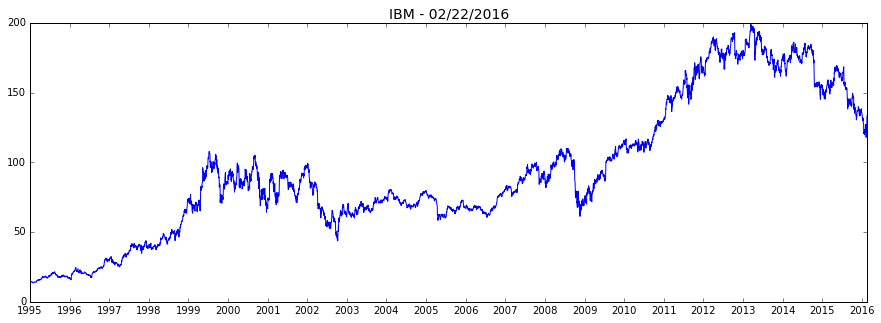

In [1]:
"""
Gaussian HMM of stock data
--------------------------
This script shows how to use Gaussian HMM on stock price data from Yahoo! finance.
"""
%matplotlib inline

from __future__ import print_function
import datetime
import numpy as np
from matplotlib import cm, pyplot as plt, finance
from matplotlib.dates import YearLocator, MonthLocator
from hmmlearn.hmm import GaussianHMM

###############################################################################
# Get quotes from Yahoo! finance
###############################################################################
ticker = "IBM"
start_date = datetime.date(1995, 1, 1)
end_date = datetime.date.today() - datetime.timedelta(days=15)
quotes = finance.quotes_historical_yahoo_ochl(ticker, start_date, end_date)

# Unpack quotes
dates = np.array([q[0] for q in quotes], dtype=int)
close_v = np.array([q[2] for q in quotes])
volume = np.array([q[5] for q in quotes])[1:]

# Take diff of close value. Note that this makes
# ``len(diff) = len(close_t) - 1``, therefore, other quantities also
# need to be shifted by 1.
diff = np.diff(close_v)
dates = dates[1:]
close_v = close_v[1:]

# Pack diff and volume for training.
X = np.column_stack([diff, volume])
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker + " - " + end_date.strftime("%m/%d/%Y"), fontsize = 14)
plt.gca().xaxis.set_major_locator(YearLocator())
plt.plot_date(dates,close_v,"-")
plt.show()

### Fit HMM and calculate State Transition Matrix

In [2]:
###############################################################################
# Run Gaussian HMM
###############################################################################
print("fitting to HMM and decoding ...", end="")
# Make an HMM instance and execute fit
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000).fit(X)
# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)
print("done")

###############################################################################
# Print trained parameters and plot
###############################################################################
print("Transition matrix")
print(model.transmat_)
print()

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))
    print()

fitting to HMM and decoding ...done
Transition matrix
[[  8.68640679e-01   3.49366766e-02   4.04460291e-02   5.59766151e-02]
 [  7.29117908e-02   5.35065575e-01   3.53778681e-01   3.82439534e-02]
 [  1.02031902e-01   1.27119463e-01   7.70848635e-01   3.07785660e-12]
 [  7.16818642e-02   1.54534898e-02   5.29184154e-08   9.12864593e-01]]

Means and vars of each hidden state
0th hidden state
mean =  [  6.78620873e-02   6.49996858e+06]
var =  [  1.45564203e+00   1.89495967e+12]

1th hidden state
mean =  [ -2.33948578e-01   1.62218766e+07]
var =  [  1.15099908e+01   6.26598572e+13]

2th hidden state
mean =  [  5.01291704e-02   1.03467910e+07]
var =  [  1.11274672e+00   5.78012696e+12]

3th hidden state
mean =  [  2.89970090e-02   4.00915929e+06]
var =  [  1.58831011e+00   9.48692358e+11]



### Plot states 

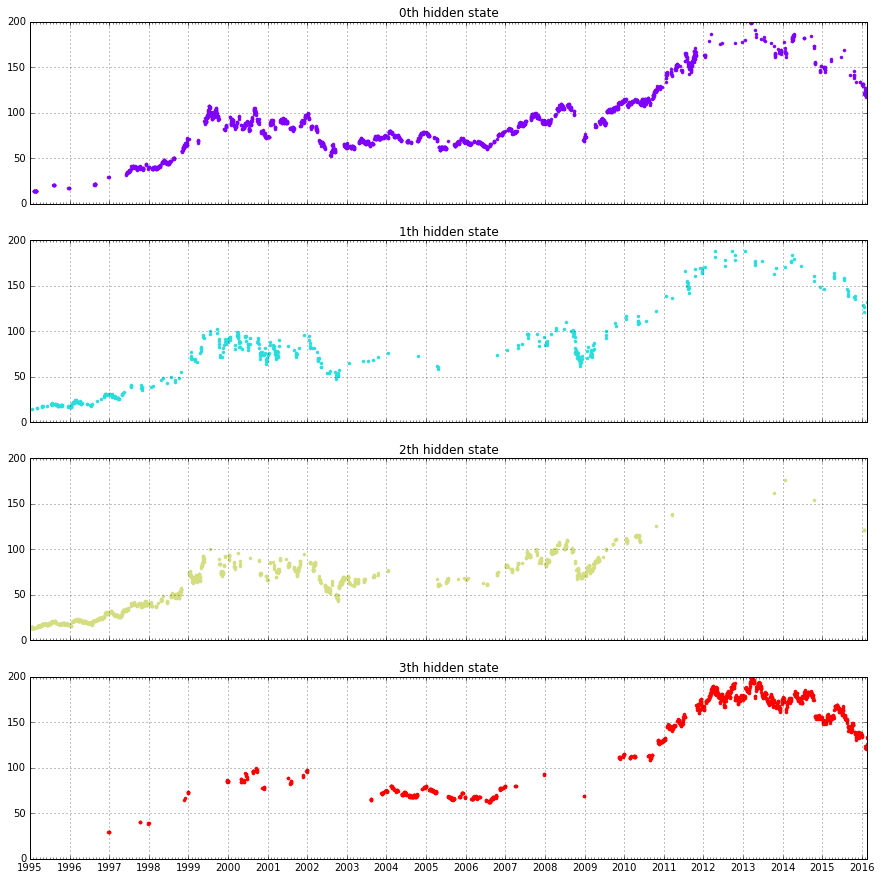

In [3]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)
plt.show()

### Predict Stock price for last N days

In [4]:
#get quotes for last N days
start_date = datetime.date.today() - datetime.timedelta(days=15)
end_date = datetime.date.today() 
quotes = finance.quotes_historical_yahoo_ochl(ticker,start_date,end_date)
dates = np.array([q[0] for q in quotes], dtype=int)

In [5]:
#predict returns for last N days
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volumes_columnwise = list(zip(*expected_returns_and_volumes))
returns = returns_and_volumes_columnwise[0]

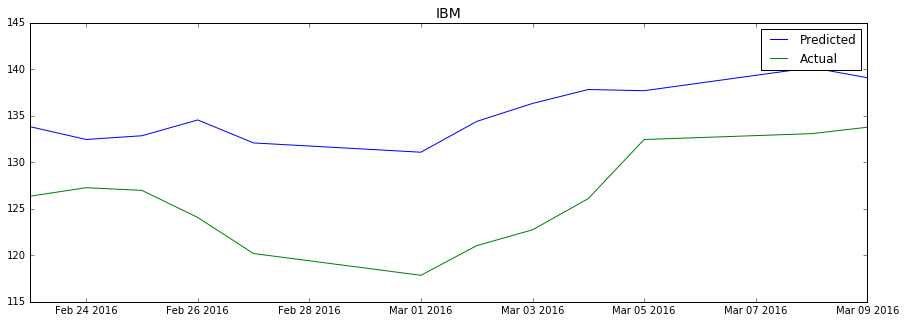

In [6]:
predicted_prices = []
predicted_dates = []

lastN = 12
for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = quotes[-lastN+idx][2]
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + returns[state])

plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,predicted_prices)
plt.plot(predicted_dates,close_v[-lastN:])
plt.legend(['Predicted','Actual'])
plt.show()